## SLIC

[SLIC Superpixels](https://www.researchgate.net/publication/44234783)

<p style='direction:rtl; text-align: right'>
در این کد، روش SLIC بر طبق مقاله اصلی آن پیاده شده است که لینک این مقاله در بالای صفحه آمده است.
<br><br>
ابتدا مراکز سوپرپیکسل‌ها را معین میکنیم. تمامی مرکزها را با فاصله ثابتی در یک ساختار جدولی قرار می‌دهیم و
فاصله‌های جدول را به گونه‌ای تعیین میکنیم که تعداد سوپرپیکسل‌ها به تعداد ورودی، نزدیک‌ترین حالت باشد.
برای تعیین فاصله، از این نکته استفاده میکنیم که اگر تعداد کل پیکسل‌ها N باشد، هر سوپرپیکسل تقریبن N/K پیکسل را در بر میگیرد
که K تعداد سوپرپیکسل‌های موردنظر است.
پس فواصل جدول به طور تقریبی S=sqrt(N/K) هستند.
<br><br>
حال برای کاهش نویز در انتخاب سوپرپیکسل‌ها، مراکز را در یک همسایگی b×b جا به جا میکنیم تا روی کمترین گرادیان قرار گیرد.
<br><br>
در هر ایتریشن از SLIC، هر پیکسل را به نزدیک ترین مرکزی اختصاص می‌دهیم که در همسایگی 2S*2S از مرکز سوپر پیکسل قرار دارد.
فاصله را به صورت زیر تعریف میکنیم:
</p>

$$ D = D_{lab} + \frac{m}{S} D_{xy} $$

<p style='direction:rtl; text-align: right'>
که در اینجا m یک پارامتر است که طبق نتایج مقاله، در موارد کاربردی m=10 پاسخگویی مناسبی دارد.
همچنین متغیر فاصله را، با توجه به اینکه وابسته به اندازه عکس و تعداد سوپرپیکسل‌هاست، با تقسیم بر S اسکیل میکنیم.
</p>

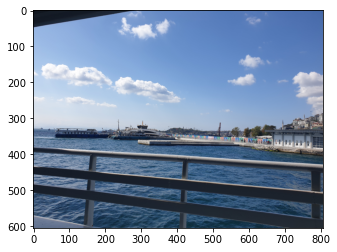

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import math
import itertools
from skimage.segmentation import mark_boundaries

img = plt.imread('./data/slic.jpg')
r_img = cv.resize(img, (0, 0), img, 0.2, 0.2, cv.INTER_AREA)
plt.imshow(r_img)
plt.show()

In [2]:
src = cv.cvtColor(r_img, cv.COLOR_RGB2Lab).astype(float)
src = cv.GaussianBlur(src, (7, 7), 2)

K = 1024
m = 10
nb = 5
eps = 8
max_iters = 3
N = src.shape[0] * src.shape[1]
S = int(math.sqrt(N / K))

# generating gradient
sobel_x = cv.Sobel(src, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(src, cv.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
grad = np.mean(grad, axis=2)

# creating clusters
src = np.concatenate((np.dstack(np.mgrid[:src.shape[0], :src.shape[1]]), src), axis=2)
cluster_centers = np.array(list(itertools.product(np.arange(S, src.shape[0], S),
                                                  np.arange(S, src.shape[1], S))))

# perturbing
for clus in cluster_centers:
    mn = math.inf
    argmn = [0, 0]

    up = max(0, int(clus[0] - nb // 2))
    left = max(0, int(clus[1] - nb // 2))
    down = min(src.shape[0], int(clus[0] + nb // 2 + 1))
    right = min(src.shape[1], int(clus[1] + nb // 2 + 1))

    for i in range(up, down):
        for j in range(left, right):
            if grad[i, j] < mn:
                mn = grad[i, j]
                argmn = [i, j]
    clus[:2] = argmn

# generate color for cluster centers
cluster_centers = src[tuple(cluster_centers.T)]

<p style='direction:rtl; text-align: right'>
همچینین برای کاهش نویز، یک فیلتر گوسی نیز اعمال کردیم و برای جلوگیری از حرکت سوپرپیکسل ها در اثر نویز، یک eps تعریف میکنیم که
ترشهولدی برای اساین شدن یک پیکسل به سوپرپیکسل جدید است.
<br>
با توجه به نتایج مقاله، این روش پس از ۴ الی حداکثر ۱۰ بار اجرا تقریبن همگرا می‌شود. در اینجا ۳ بار انجام می‌دهیم.
</p>

end iteration 0
end iteration 1
end iteration 2


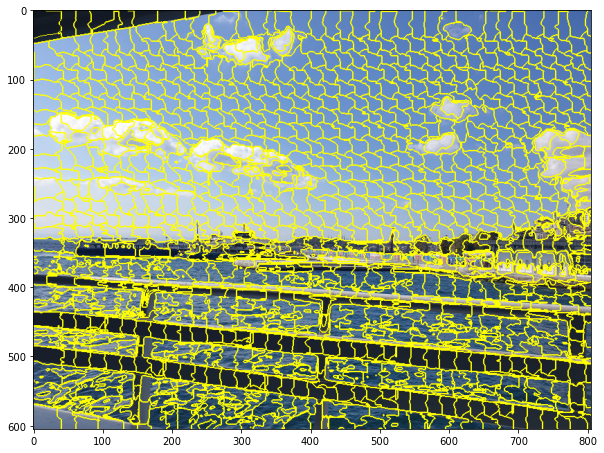

In [3]:
lbl = np.ones(src.shape[:2]) * -1
mtc = np.ones(src.shape[:2]) * math.inf
for it in range(max_iters):
    # lbl *= 0
    # lbl -= 1
    # mtc += math.inf
    # assign pixels to clusters
    for t, clus in enumerate(cluster_centers):
        up = max(0, int(clus[0] - S))
        left = max(0, int(clus[1] - S))
        down = min(src.shape[0], int(clus[0] + S + 1))
        right = min(src.shape[1], int(clus[1] + S + 1))
        for i in range(up, down):
            for j in range(left, right):
                px = src[i, j]
                dist_lab = np.linalg.norm(clus[2:] - px[2:])
                dist_xy = np.linalg.norm(clus[:2] - px[:2])
                dist = dist_lab + dist_xy * m / S
                if dist + eps < mtc[i, j]:
                    mtc[i, j] = dist
                    lbl[i, j] = t
    # recalculate cluster centers
    for t in range(len(cluster_centers)):
        lkup = src[lbl == t]
        if len(lkup) > 0:
            tmp = np.mean(lkup, axis=0)
            cluster_centers[t] = tmp
    print(f'end iteration {it}')

res = src.copy()

plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(r_img, lbl.astype(int)))
plt.show()

